In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 100)

In [2]:
file_paths = {'in':'../../data/cleaned/activities/4439566437.csv'
             }

df = pd.read_csv(file_paths['in'])

# guarantee the timestamps are datetime objects
df['time'] = pd.to_datetime(df['time'])

In [4]:
if 'index' in df.columns:
    df.drop(['index'], axis=1, inplace=True)

In [5]:
df.head()

,time,ride_id,segment_id,elevation,latitude,longitude,elapsed_time,delta_time,moving_time,delta_dist,heading,speed,is_cruising,grade,elapsed_ascent,elapsed_descent,elapsed_elevation,training_window_id
0,2020-12-06 18:36:38+00:00,4.439566e+09,0.0,884.8857,40.067950,-83.127786,1.0,1.0,1.0,NaN,NaN,NaN,False,NaN,0.0,0.0,0.0,6
1,2020-12-06 18:36:39+00:00,4.439566e+09,0.0,884.8857,40.067975,-83.127779,2.0,1.0,2.0,0.001739,72.979474,6.259034,False,0.0,0.0,0.0,0.0,6
2,2020-12-06 18:36:40+00:00,4.439566e+09,0.0,884.8857,40.067999,-83.127771,3.0,1.0,3.0,0.001739,72.979474,6.259034,False,0.0,0.0,0.0,0.0,6
3,2020-12-06 18:36:41+00:00,4.439566e+09,0.0,884.8857,40.068021,-83.127801,4.0,1.0,4.0,0.002197,143.746162,7.909226,False,0.0,0.0,0.0,0.0,6
4,2020-12-06 18:36:42+00:00,4.439566e+09,0.0,884.8857,40.068023,-83.127808,5.0,1.0,5.0,0.000395,164.054604,1.422308,False,0.0,0.0,0.0,0.0,6


### Grab Segment 22 as the longest representative segment

In [10]:
df22 = df.loc[df['segment_id']==22,:].reset_index()

# 1. Initial Speed Investigation

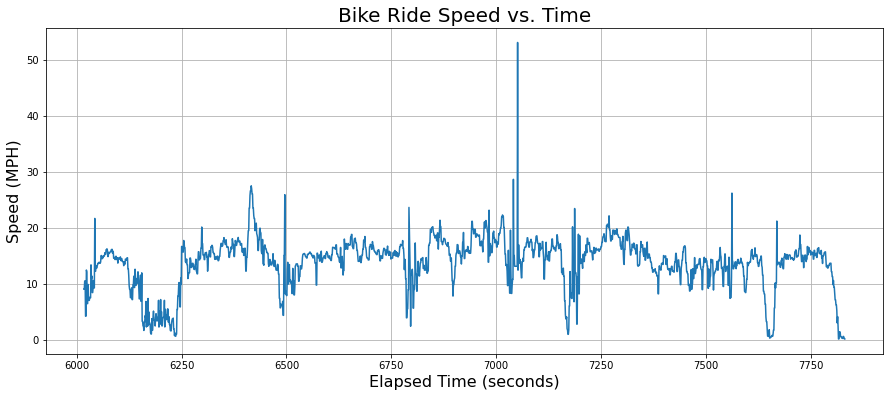

In [23]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(15,6))

_ = sns.lineplot(x='elapsed_time', y='speed', data=df22)
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Speed (MPH)', fontsize=16)
_ = plt.title('Bike Ride Speed vs. Time', fontsize=20)
_ = plt.grid()

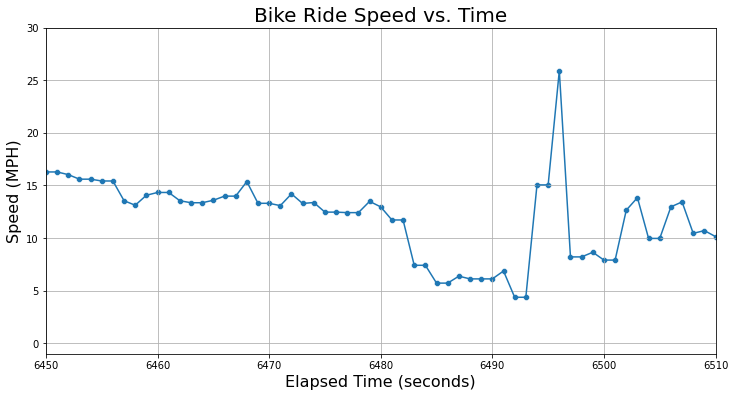

In [22]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(12,6))

_ = sns.lineplot(x='elapsed_time', y='speed', data=df22)
_ = sns.scatterplot(x='elapsed_time', y='speed', data=df22)
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Speed (MPH)', fontsize=16)
_ = plt.title('Bike Ride Speed vs. Time', fontsize=20)
_ = plt.grid()
_ = plt.xlim([6450, 6510])
_ = plt.ylim([-1,30])

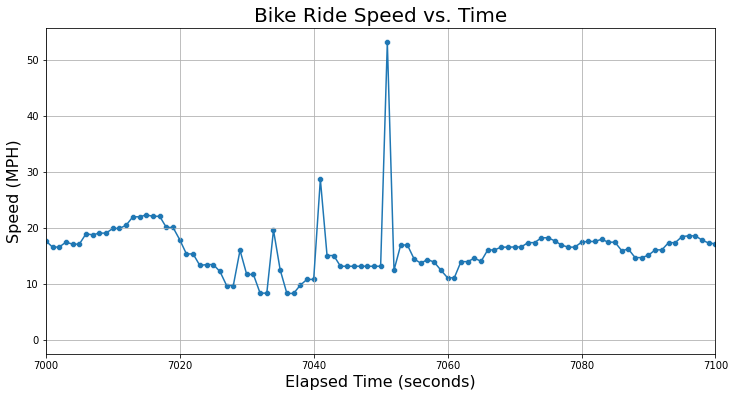

In [21]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(12,6))

_ = sns.lineplot(x='elapsed_time', y='speed', data=df22)
_ = sns.scatterplot(x='elapsed_time', y='speed', data=df22)
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Speed (MPH)', fontsize=16)
_ = plt.title('Bike Ride Speed vs. Time', fontsize=20)
_ = plt.grid()
_ = plt.xlim([7000, 7100])
#_ = plt.ylim([-1,30])

### Speed Frequency Spectrum
Helper refresher and syntax: https://realpython.com/python-scipy-fft/

In [27]:
from scipy.fft import rfft, rfftfreq

In [94]:
np.log10

<ufunc 'log10'>

In [101]:
from scipy.fft import rfft, rfftfreq

def plot_signal_fft(df, signal_column, sample_rate=1.0):
    signal_list = list(df[signal_column].dropna().values)
    n_samples = len(signal_list)
    
    yf = rfft(signal_list)
    xf = rfftfreq(n_samples, 1 / sample_rate)
    
    fig = plt.figure(figsize=(12,6))

    _ = plt.semilogx(xf, 10 * np.log10(np.abs(yf)), linewidth=2.0)
    _ = plt.grid(True, which="both")
    _ = plt.ylabel('Frequency Power (dB)')
    _ = plt.xlabel('Frequency (Hz)')

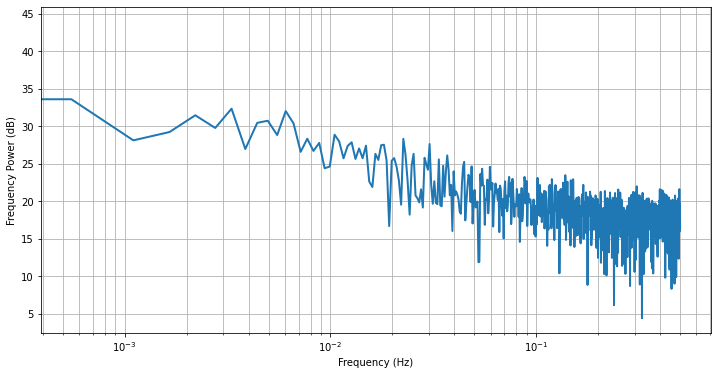

In [102]:
plot_signal_fft(df22, 'speed')

In [103]:
df22['speed'] = df22['speed'].interpolate(method='backfill')

In [112]:
df22['speed'].shape

(1816,)

In [115]:
from scipy import signal

def apply_hann_filter(df, signal_column, window_order=10):
    signal_list = list(df[signal_column].values)
    win = signal.windows.hann(window_order)
    filtered_signal = signal.convolve(speed_signal, win, mode='same') / sum(win)
    
    df['filt_'+signal_column] = np.nan
    if len(signal_list) == len(filtered_signal):
        df['filt_'+signal_column] = filtered_signal
    else:
        df.loc[1:,'filt_'+signal_column] = filtered_signal
        df.loc[0,'filt_'+signal_column] = df.loc[0,'filt_'+signal_column] # backfill
    return df

In [116]:
df22 = apply_hann_filter(df22, 'speed')

1816 1815


In [117]:
df22

,index,time,ride_id,segment_id,elevation,latitude,longitude,elapsed_time,delta_time,moving_time,delta_dist,heading,speed,is_cruising,grade,elapsed_ascent,elapsed_descent,elapsed_elevation,training_window_id,filt_speed
0,5010,2020-12-06 20:16:53+00:00,4.439566e+09,22.0,862.24680,40.154175,-83.122699,6016.0,1.0,5011.0,NaN,260.380272,9.042819,False,NaN,453.76230,476.4012,930.16350,6,NaN
1,5011,2020-12-06 20:16:54+00:00,4.439566e+09,22.0,862.24680,40.154140,-83.122714,6017.0,1.0,5012.0,0.002512,246.501434,9.042819,True,0.00000,453.76230,476.4012,930.16350,6,4.693896
2,5012,2020-12-06 20:16:55+00:00,4.439566e+09,22.0,862.24680,40.154106,-83.122729,6018.0,1.0,5013.0,0.002512,246.501434,9.042819,True,0.00000,453.76230,476.4012,930.16350,6,6.723352
3,5013,2020-12-06 20:16:56+00:00,4.439566e+09,22.0,862.41085,40.154073,-83.122764,6019.0,1.0,5014.0,0.002919,223.726970,10.506904,True,1.06456,453.92635,476.4012,930.32755,6,7.968605
4,5014,2020-12-06 20:16:57+00:00,4.439566e+09,22.0,862.57490,40.154040,-83.122798,6020.0,1.0,5015.0,0.002919,223.726970,10.506906,True,1.06456,454.09040,476.4012,930.49160,6,8.280448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1811,6821,2020-12-06 20:47:04+00:00,4.439566e+09,22.0,876.02700,40.076834,-83.128422,7827.0,1.0,6822.0,0.000168,30.963757,0.604659,False,0.00000,712.30510,721.1638,1433.46890,6,0.435655
1812,6822,2020-12-06 20:47:05+00:00,4.439566e+09,22.0,876.02700,40.076835,-83.128420,7828.0,1.0,6823.0,0.000168,30.963757,0.604659,False,0.00000,712.30510,721.1638,1433.46890,6,0.439418
1813,6823,2020-12-06 20:47:06+00:00,4.439566e+09,22.0,876.02700,40.076836,-83.128418,7829.0,1.0,6824.0,0.000126,26.565051,0.454719,False,0.00000,712.30510,721.1638,1433.46890,6,0.402307
1814,6824,2020-12-06 20:47:07+00:00,4.439566e+09,22.0,876.02700,40.076836,-83.128417,7830.0,1.0,6825.0,0.000044,45.000000,0.156600,False,0.00000,712.30510,721.1638,1433.46890,6,0.320613


In [83]:
from scipy import signal

In [87]:
speed_signal = list(df22['speed'].dropna().values)
win = signal.windows.hann(10)
filtered_speed = signal.convolve(speed_signal, win, mode='same') / sum(win)

In [88]:
len(speed_signal), len(filtered_speed)

(1815, 1815)

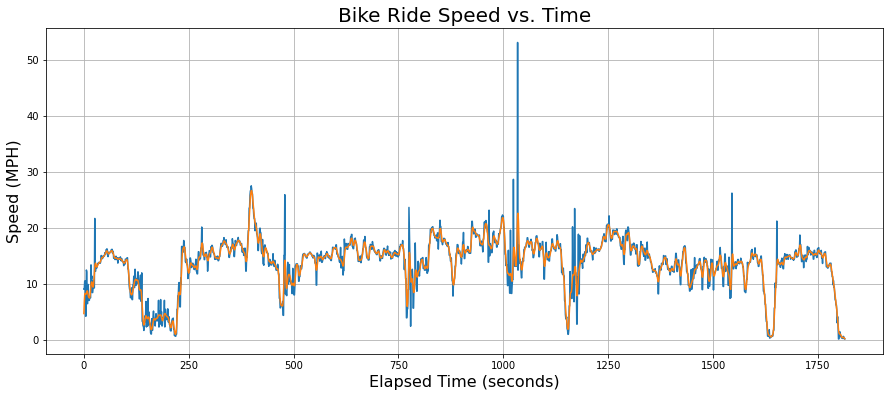

In [89]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(15,6))

_ = plt.plot(speed_signal)
_ = plt.plot(filtered_speed)
_ = plt.xlabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.ylabel('Speed (MPH)', fontsize=16)
_ = plt.title('Bike Ride Speed vs. Time', fontsize=20)
_ = plt.grid()

In [93]:
df22['speed']

0             NaN
1        9.042819
2        9.042819
3       10.506904
4       10.506906
          ...    
1811     0.604659
1812     0.604659
1813     0.454719
1814     0.156600
1815     0.156600
Name: speed, Length: 1816, dtype: float64

In [92]:
df22['speed'].interpolate(method='backfill')

0        9.042819
1        9.042819
2        9.042819
3       10.506904
4       10.506906
          ...    
1811     0.604659
1812     0.604659
1813     0.454719
1814     0.156600
1815     0.156600
Name: speed, Length: 1816, dtype: float64